In [20]:
# Importing necessary libraries for data analysis and visualization

import json
from datetime import datetime

import matplotlib.pyplot as plt  # For creating various plots and visualizations
import numpy as np
import pandas as pd  # For handling and manipulating structured data (tables, CSV, etc.)
import seaborn as sns  # For advanced data visualization with statistical capabilities
# Importing automatic data profiling tool
import ydata_profiling as yd  # Used to generate a report with statistics, correlations, and distributions for data exploration
# Importing time series analysis tools from pandas and statsmodels
from pandas.plotting import \
    lag_plot  # For visualizing lag correlations in time series data
from statsmodels.graphics.tsaplots import (  # For plotting autocorrelation (ACF) and partial autocorrelation (PACF)
    plot_acf, plot_pacf)
# Importing seasonal decomposition tool for time series analysis
from statsmodels.tsa.seasonal import \
    seasonal_decompose  # To decompose a time series into trend, seasonality, and residual components
# Importing statistical test for stationarity
from statsmodels.tsa.stattools import \
    adfuller  # Augmented Dickey-Fuller (ADF) test to check stationarity of a time series


In [21]:
%matplotlib inline


In [37]:
# Load the dataset
df = pd.read_csv("datasets\Month_Value_1.csv", index_col="Period", parse_dates=True)

In [29]:
DataProfile = yd.ProfileReport(df)
DataProfile.to_file("Profile.json")
DataProfile.to_file("Profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 333.38it/s]


In [38]:
# Basic exploration
print(df.head())
print(df.info())
print(df.describe())
#df.dropna(inplace=True)

                 Revenue  Sales_quantity  Average_cost  \
Period                                                   
2015-01-01  1.601007e+07         12729.0   1257.763541   
2015-01-02  1.580759e+07         11636.0   1358.507000   
2015-01-03  2.204715e+07         15922.0   1384.697024   
2015-01-04  1.881458e+07         15227.0   1235.606705   
2015-01-05  1.402148e+07          8620.0   1626.621765   

            The_average_annual_payroll_of_the_region  
Period                                                
2015-01-01                                30024676.0  
2015-01-02                                30024676.0  
2015-01-03                                30024676.0  
2015-01-04                                30024676.0  
2015-01-05                                30024676.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-01 to 2022-01-12
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------    

In [39]:
# def handle_missing_values(df):
#     for column in df.columns:
#         if df[column].isna().sum() > 0 or np.isinf(df[column]).sum() > 0:
#             print(f"Handling missing values in {column}")

#             # Remplacer les valeurs infinies par NaN
#             df[column] = df[column].replace([np.inf, -np.inf], np.nan)

#             # Calcul du ratio de valeurs manquantes
#             missing_ratio = df[column].isna().sum() / len(df)

#             # Choix de la stratégie selon le pourcentage de NaN
#             if missing_ratio < 0.05:  
#                 strategy = "mean"  # Moins de 5% → Remplacement par la moyenne
#                 df[column].fillna(df[column].mean(), inplace=True)
#             elif missing_ratio < 0.2:  
#                 strategy = "interpolation"  # Entre 5% et 20% → Interpolation linéaire
#                 df[column].interpolate(method="linear", inplace=True)
#             else:
#                 strategy = "median"  # Plus de 20% → Remplacement par la médiane
#                 df[column].fillna(df[column].median(), inplace=True)
            
#             print(f"Applied {strategy} strategy for {column}")
#     df.to_csv("df.csv")
#     return df

In [ ]:
#df1=handle_missing_values(df)

def generate_mlops_report(df):
    """
    Generate a machine-interpretable EDA report for MLOps preprocessing
    
    Parameters:
    df (pandas.DataFrame): Input time series dataframe
    
    Returns:
    dict: Structured, machine-readable analysis report
    """
    report = {
        "dataset_metadata": {
            "total_columns": len(df.columns),
            "total_rows": len(df),
            "date_range": {
                "start": str(df.index.min()),
                "end": str(df.index.max())
            }
        },
        "preprocessing_recommendations": {
            "stationarity": {},
            "seasonality": {},
            "feature_scaling": [],
            "feature_engineering": []
        },
        "statistical_insights": {
            "descriptive_stats": {},
            "correlations": {
                "significant_correlations": [],
                "correlation_matrix": {}
            }
        }
    }
    
    # Stationarity Analysis and Seasonality Detection
    
    for column in df.columns:
        #Stationarity
        adf_result = adfuller(df[column])
        report["preprocessing_recommendations"]["stationarity"][column] = {
            "is_stationary": str(adf_result[1] < 0.05),
            "p_value": float(adf_result[1]),
            "transformation_needed": "YES" if adf_result[1] >= 0.05 else "NO"
        }
           
        # Seasonality
        seasonal_period = 12  # (12 pour mensuel, 7 pour journalier)
        decomposition = seasonal_decompose(df[column], model='additive', period=seasonal_period)
        seasonal_strength = np.var(decomposition.seasonal) / np.var(df[column])

        report["preprocessing_recommendations"]["seasonality"][column] = {
            "has_seasonality": str(seasonal_strength > 0.1),  # Threshold to detect seasonality
            "seasonal_strength": float(seasonal_strength),
            "transformation_needed": "YES" if seasonal_strength > 0.1 else "NO"
        }

        if seasonal_strength > 0.1:  # Seuil to adjust
            report["preprocessing_recommendations"]["feature_engineering"].append({
                "column": column,
                "suggested_transformations": ["seasonal_differencing", "fourier_terms"]
            })
        # Recommend transformations if not stationary
        if adf_result[1] >= 0.05:
            report["preprocessing_recommendations"]["feature_engineering"].append({
                "column": column,
                "suggested_transformations": [
                    "log_transformation",
                    "differencing",
                    "rolling_mean_normalization"
                ]
            })
    #
    
    # Descriptive Statistics
    for column in df.columns:
        report["statistical_insights"]["descriptive_stats"][column] = {
            "mean": float(df[column].mean()),
            "std": float(df[column].std()),
            "min": float(df[column].min()),
            "max": float(df[column].max())
        }
    
    # Correlation Analysis
    corr_matrix = df.corr()
    report["statistical_insights"]["correlations"]["correlation_matrix"] = \
        {str(col): {str(subcol): float(corr_matrix.loc[col, subcol]) 
                    for subcol in df.columns} 
         for col in df.columns}
    
    # Significant Correlations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                correlation = float(corr_matrix.loc[col1, col2])
                if abs(correlation) > 0.5:
                    report["statistical_insights"]["correlations"]["significant_correlations"].append({
                        "features": [col1, col2],
                        "correlation": correlation,
                        "strength": "strong" if abs(correlation) > 0.7 else "moderate"
                    })
    
    # Feature Scaling Recommendations
    for column in df.columns:
        if df[column].std() > 1:  # Suggest scaling for features with high variance
            report["preprocessing_recommendations"]["feature_scaling"].append({
                "column": column,
                "recommended_method": ["standardization", "min_max_scaling"]
            })
    
    return report

# Generate and save the report
final_report = generate_mlops_report(df)

# Save to JSON
with open('mlops_eda_report.json', 'w') as f:
    json.dump(final_report, f, indent=4)

print("MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'")

MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'


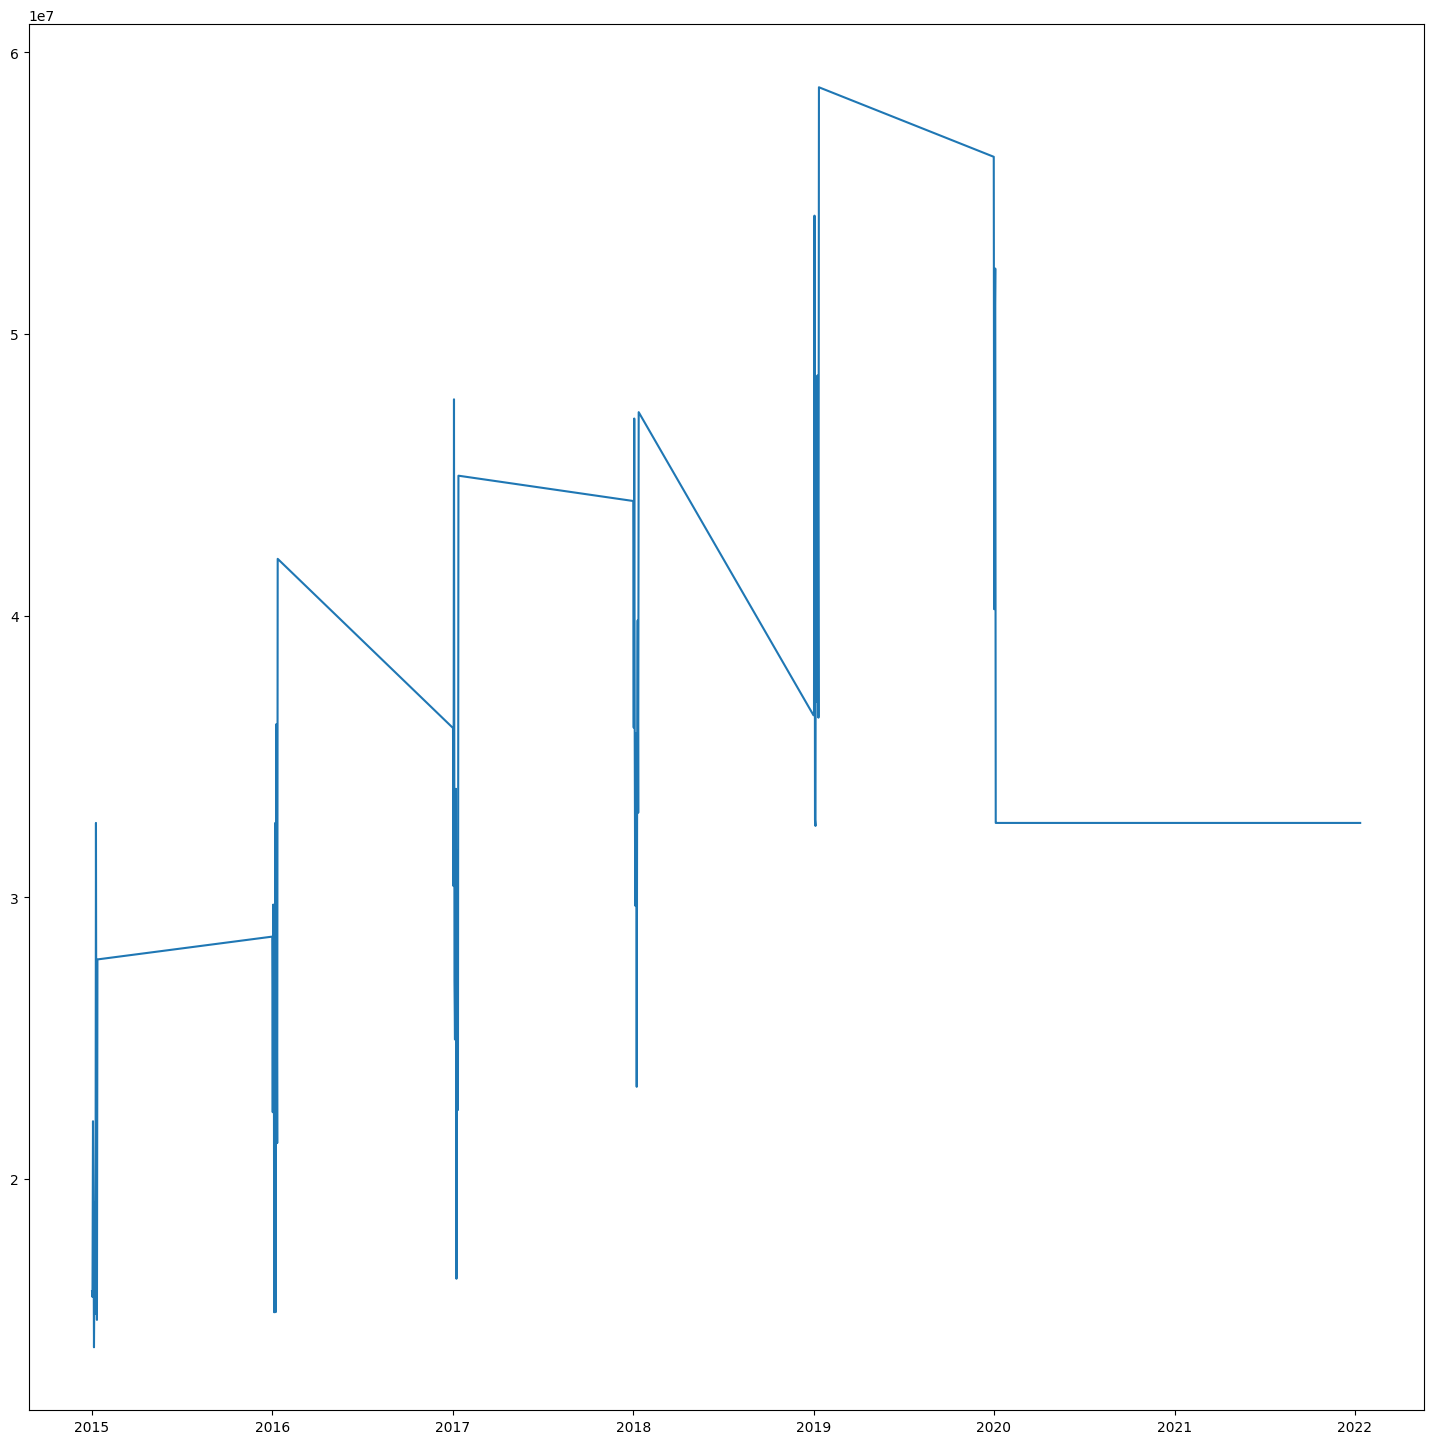

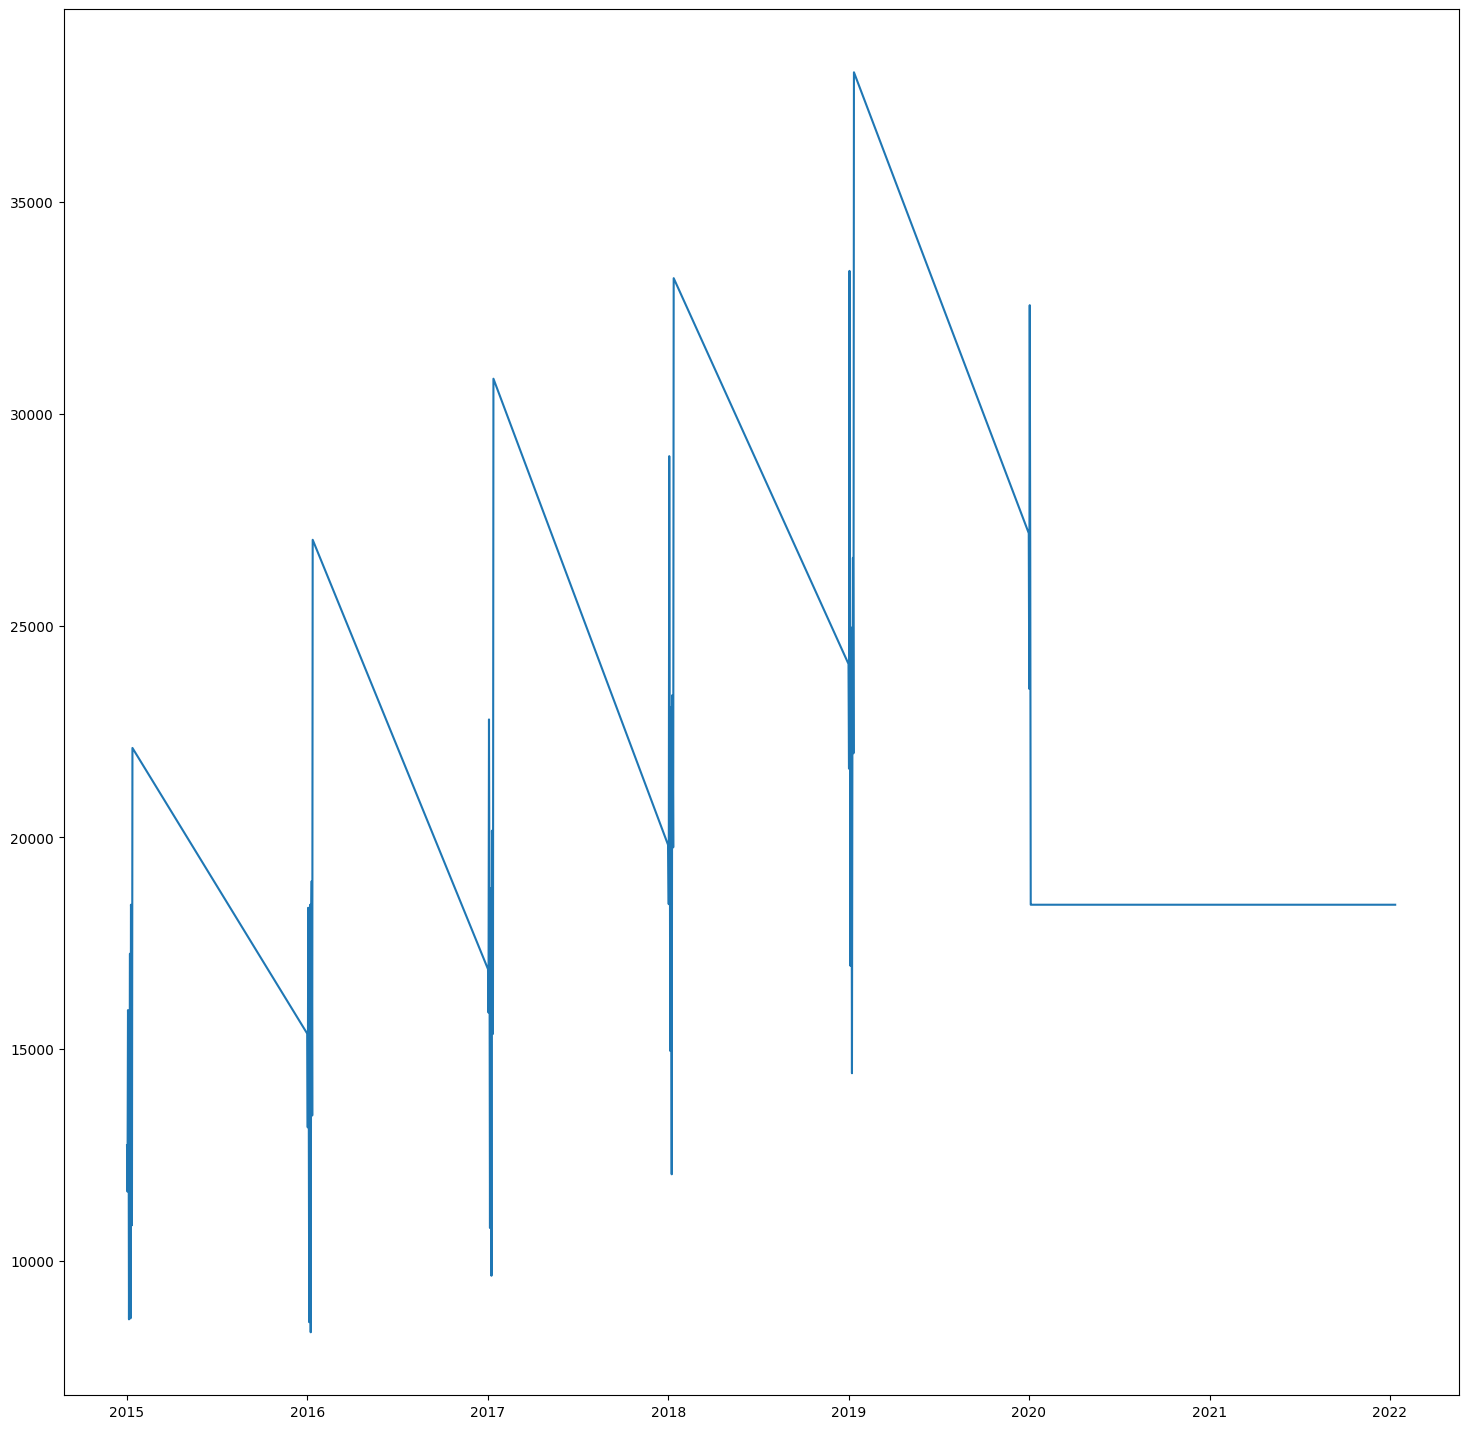

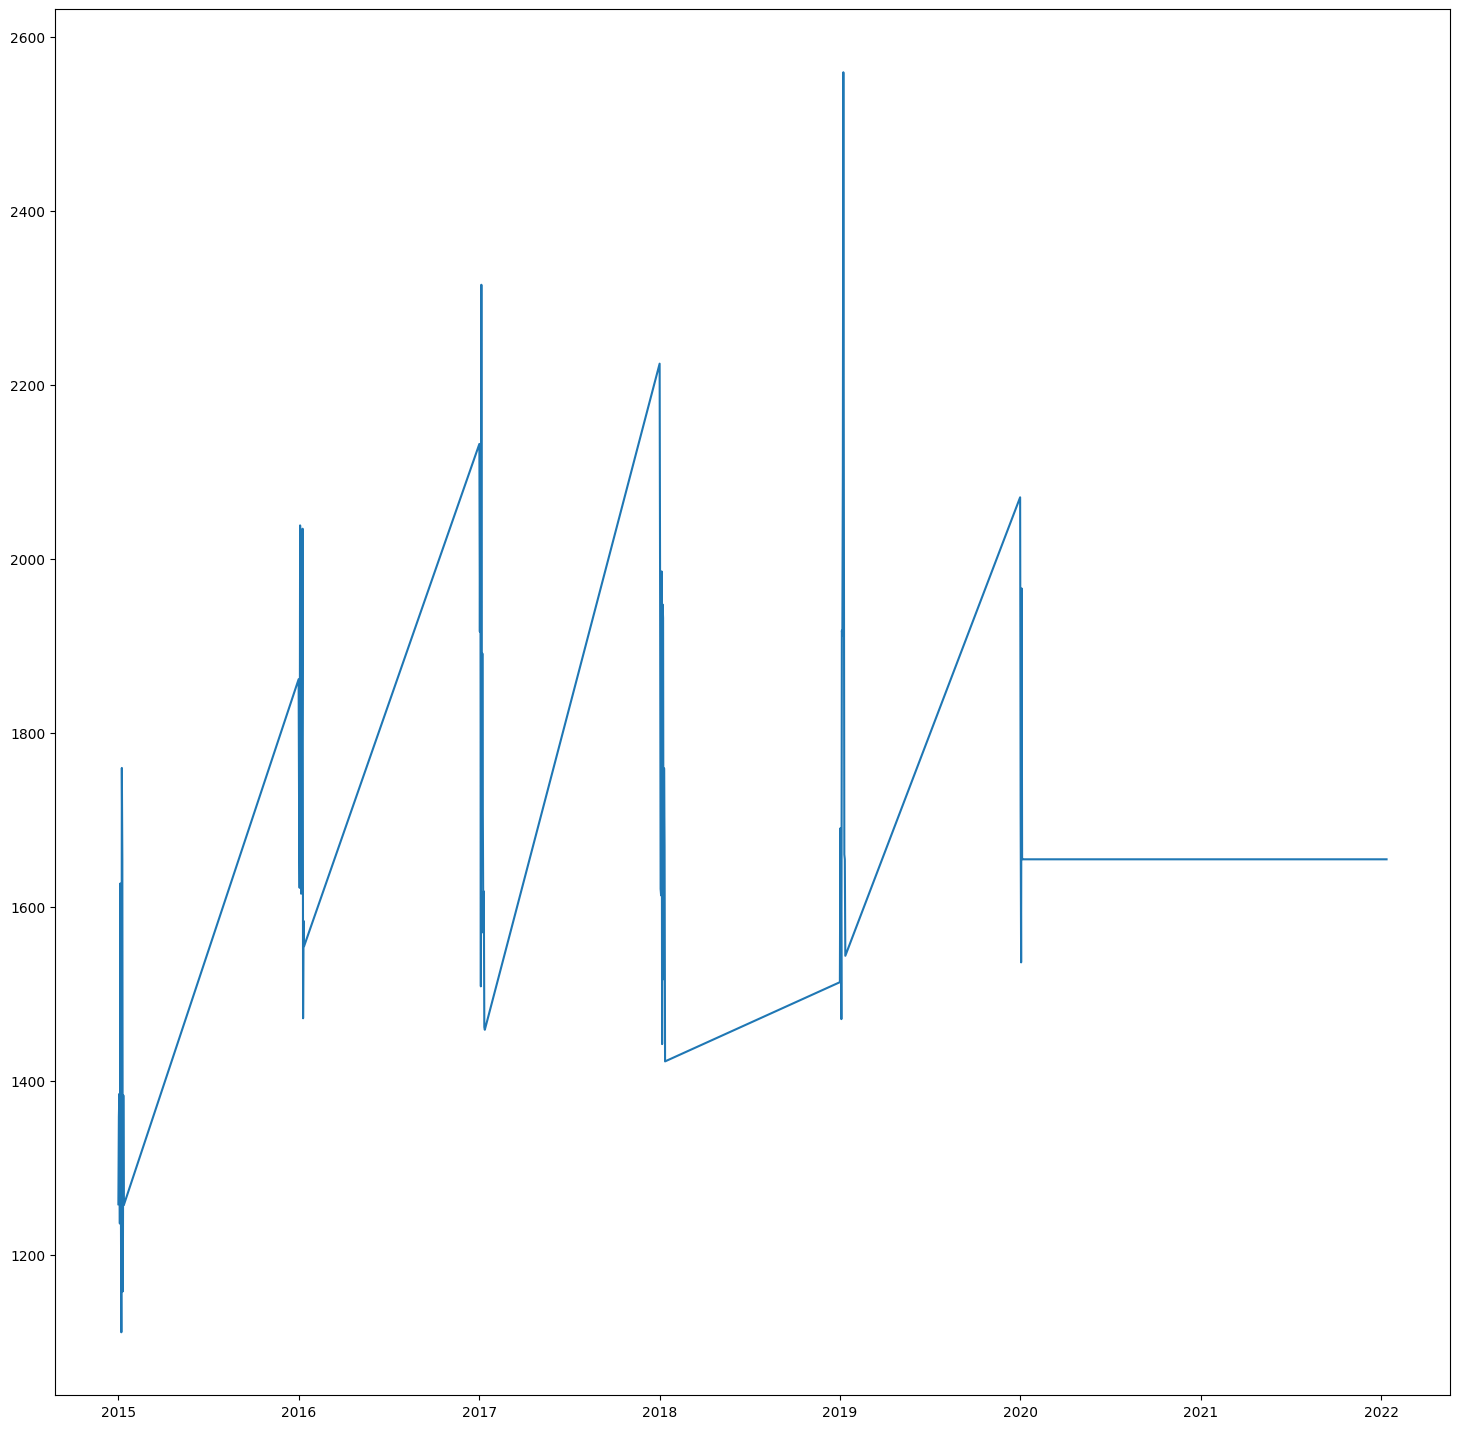

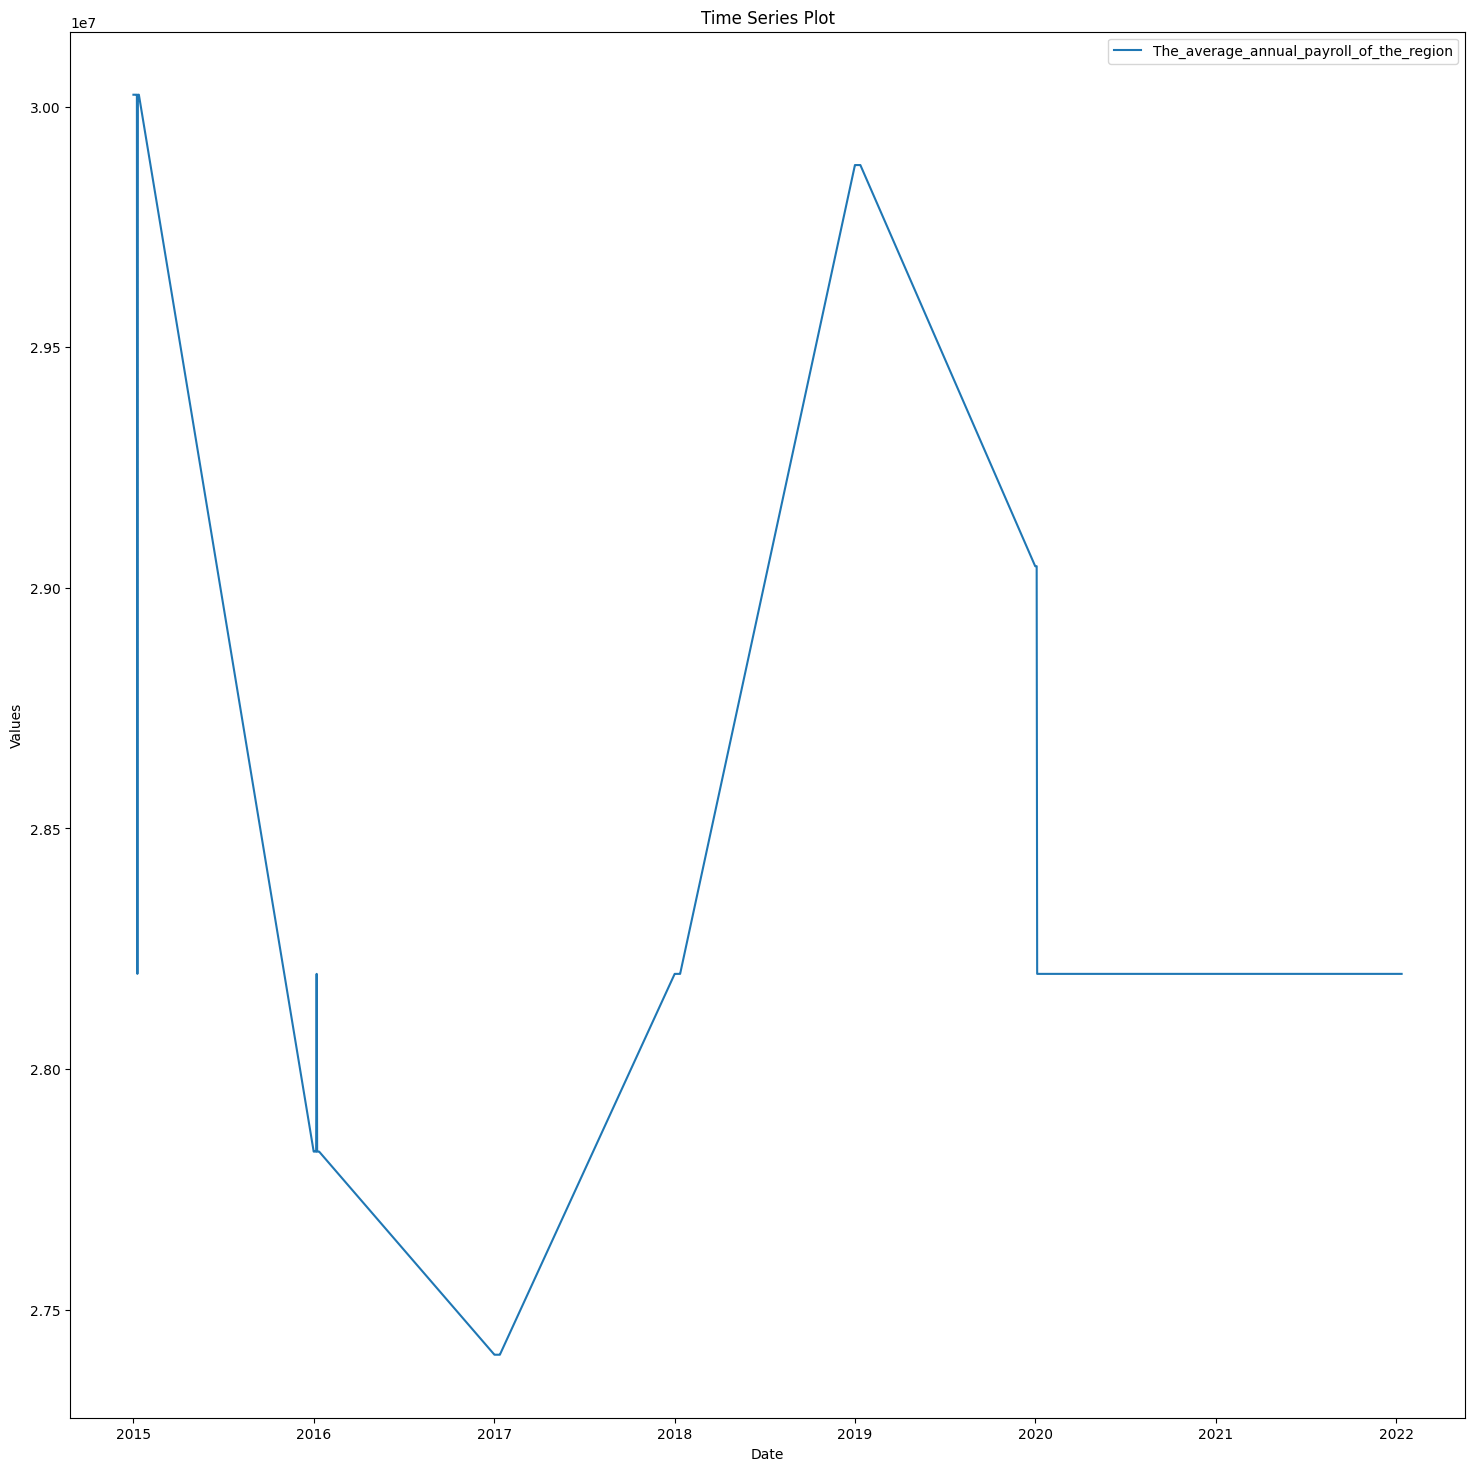

In [41]:
for column in df.columns:
    plt.figure(df.columns.get_loc(column)+1,figsize=(18, 18))
    # Plot the time series data for the current column
    plt.plot(df.index, df[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()



Analyzing column: Revenue
ADF Statistic for Revenue: -0.26914893564362996
p-value for Revenue: 0.9297615379617786


<Figure size 2000x1400 with 0 Axes>

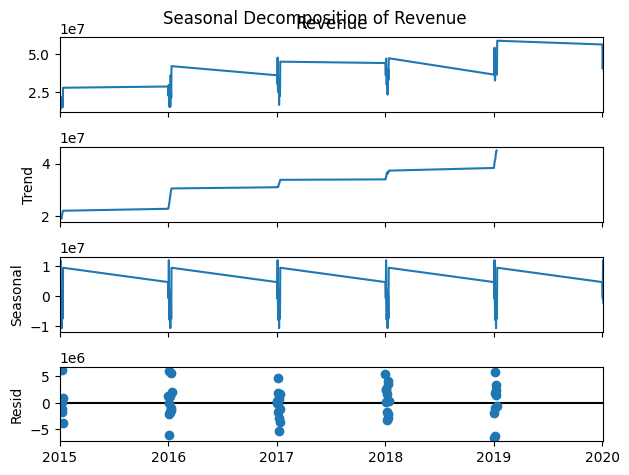


Analyzing column: Sales_quantity
ADF Statistic for Sales_quantity: 1.1570562060945375
p-value for Sales_quantity: 0.9956753282590142


<Figure size 2000x1400 with 0 Axes>

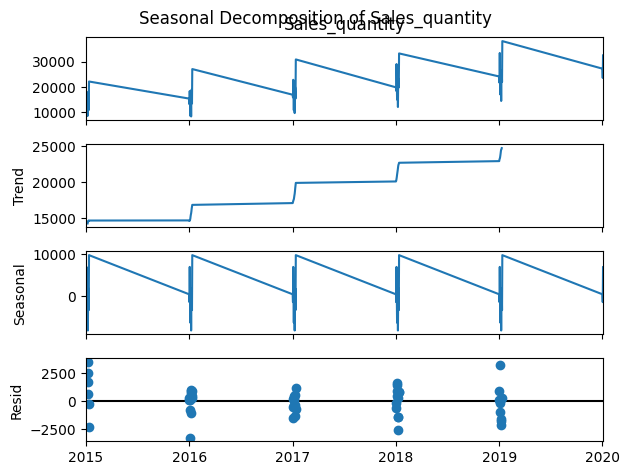


Analyzing column: Average_cost
ADF Statistic for Average_cost: -5.751134561254756
p-value for Average_cost: 5.962883288959485e-07


<Figure size 2000x1400 with 0 Axes>

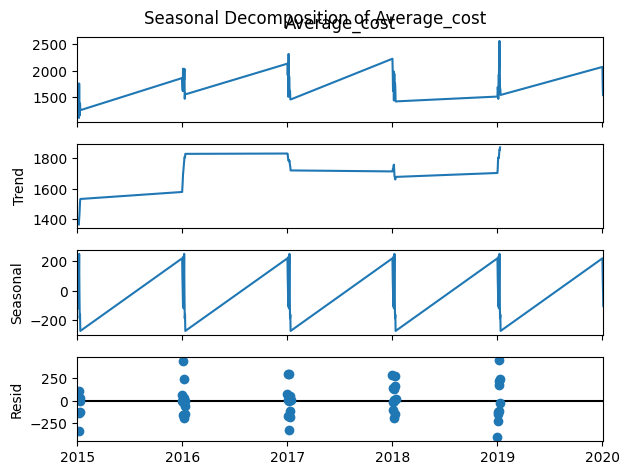


Analyzing column: The_average_annual_payroll_of_the_region
ADF Statistic for The_average_annual_payroll_of_the_region: -1.705837113111716
p-value for The_average_annual_payroll_of_the_region: 0.4281075578397735


<Figure size 2000x1400 with 0 Axes>

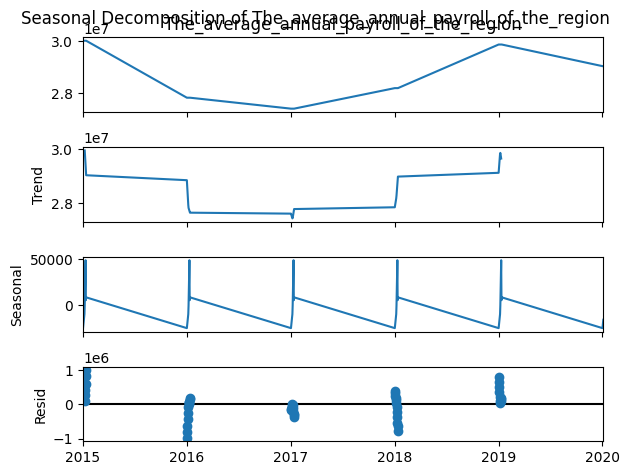

In [33]:

# Loop through each column in the DataFrame to perform stationarity testing and seasonal decomposition
for column in df.columns:
    print(f"\nAnalyzing column: {column}")  # Print the name of the column being analyzed
    
    # Create a new figure for the decomposition plot
    plt.figure(figsize=(20, 14))

    # --- Augmented Dickey-Fuller (ADF) Test for Stationarity ---
    adf_result = adfuller(df[column])  # Perform the ADF test on the current column
    print(f"ADF Statistic for {column}: {adf_result[0]}")  # Print the test statistic
    print(f"p-value for {column}: {adf_result[1]}")  # Print the p-value (to check stationarity)
    
    # The ADF test helps determine if a time series is stationary.
    # If p-value < 0.05, we reject the null hypothesis and conclude that the series is stationary.

    # --- Seasonal Decomposition ---
    # Decompose the time series into trend, seasonality, and residuals using an additive model
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    
    # Plot the decomposition results (observed, trend, seasonal, and residual components)
    decomposition.plot()
    
    # Set a title for the decomposition plot
    plt.suptitle(f'Seasonal Decomposition of {column}')
    
    # Display the plots
    plt.show()


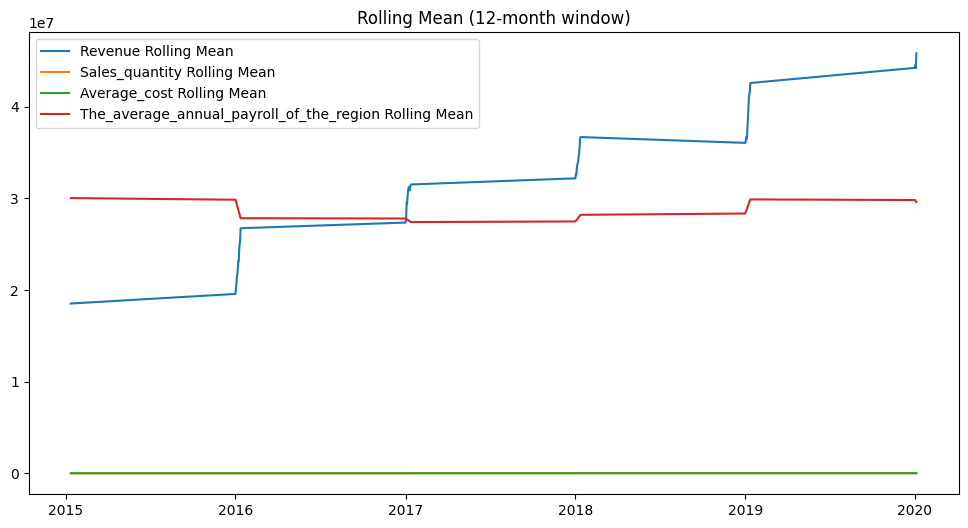

In [34]:
# Compute the rolling mean with a 12-month window for smoothing time series data
rolling_means = df.rolling(window=12).mean()

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Loop through each column in the DataFrame to plot its rolling mean
for column in df.columns:
    plt.plot(rolling_means.index, rolling_means[column], label=f'{column} Rolling Mean')

# Set the title of the plot
plt.title('Rolling Mean (12-month window)')

# Add a legend to indicate which rolling mean corresponds to which column
plt.legend()

# Display the plot
plt.show()



Correlation Matrix:
                                           Revenue  Sales_quantity  \
Revenue                                   1.000000        0.887570   
Sales_quantity                            0.887570        1.000000   
Average_cost                              0.358278       -0.093599   
The_average_annual_payroll_of_the_region -0.007111        0.103704   

                                          Average_cost  \
Revenue                                       0.358278   
Sales_quantity                               -0.093599   
Average_cost                                  1.000000   
The_average_annual_payroll_of_the_region     -0.305145   

                                          The_average_annual_payroll_of_the_region  
Revenue                                                                  -0.007111  
Sales_quantity                                                            0.103704  
Average_cost                                                             -0.305145 

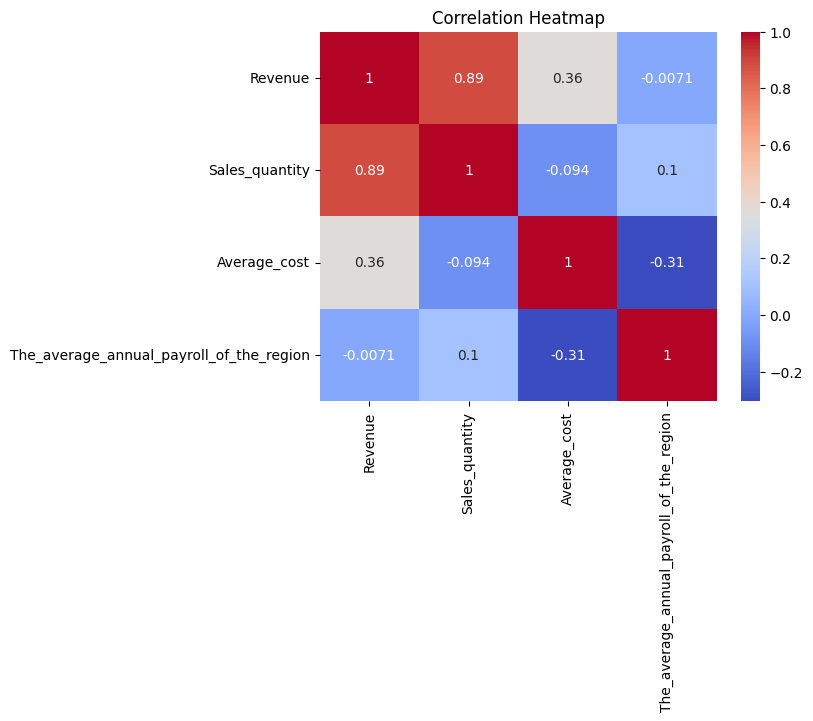

In [35]:
# Compute the correlation matrix for all numerical columns in the DataFrame
df_corr = df.corr()

# Print the correlation matrix to inspect the numerical relationships between variables
print("Correlation Matrix:")
print(df_corr)

# Create a heatmap to visualize the correlation matrix
sns.heatmap(df_corr, annot=True, cmap='coolwarm')

# Set the title for the heatmap
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()



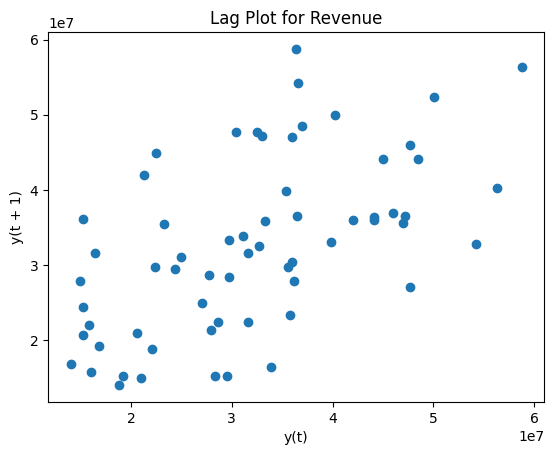

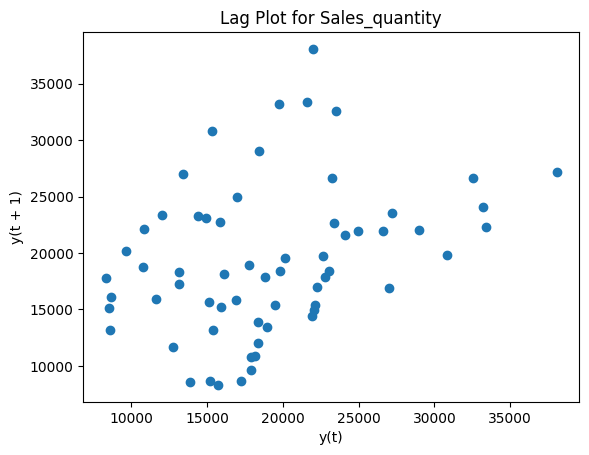

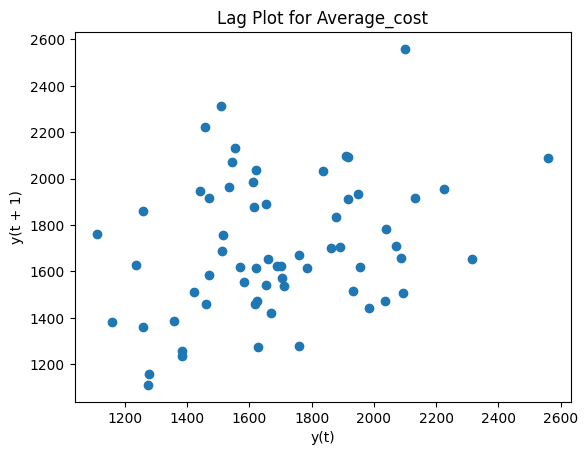

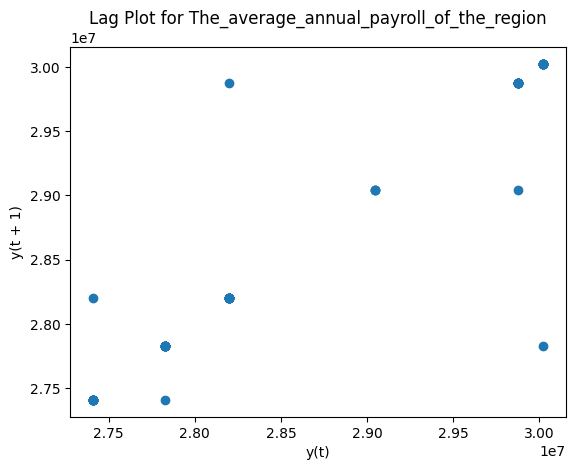

In [36]:
for column in df.columns:
    plt.figure()
    lag_plot(df[column])
    plt.title(f'Lag Plot for {column}')
    plt.show()


Autocorrelation and Partial Autocorrelation for Revenue


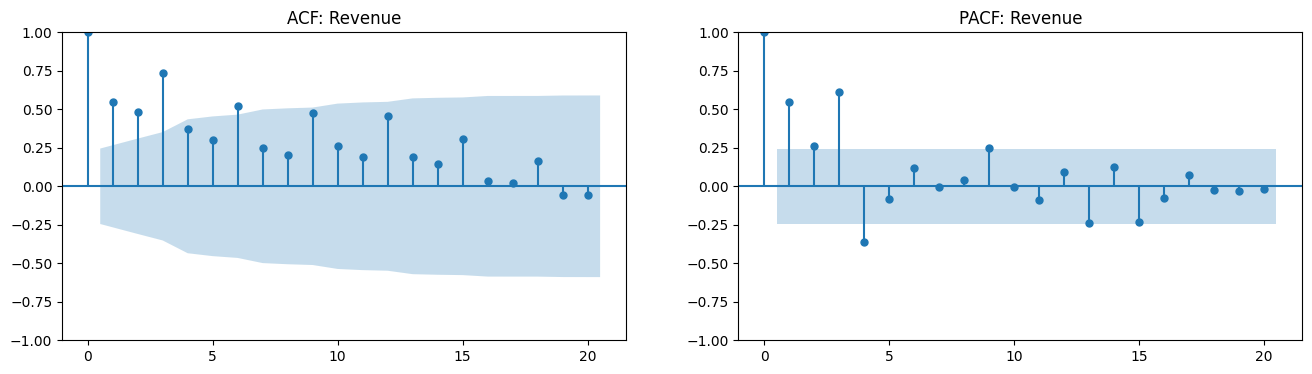

Autocorrelation and Partial Autocorrelation for Sales_quantity


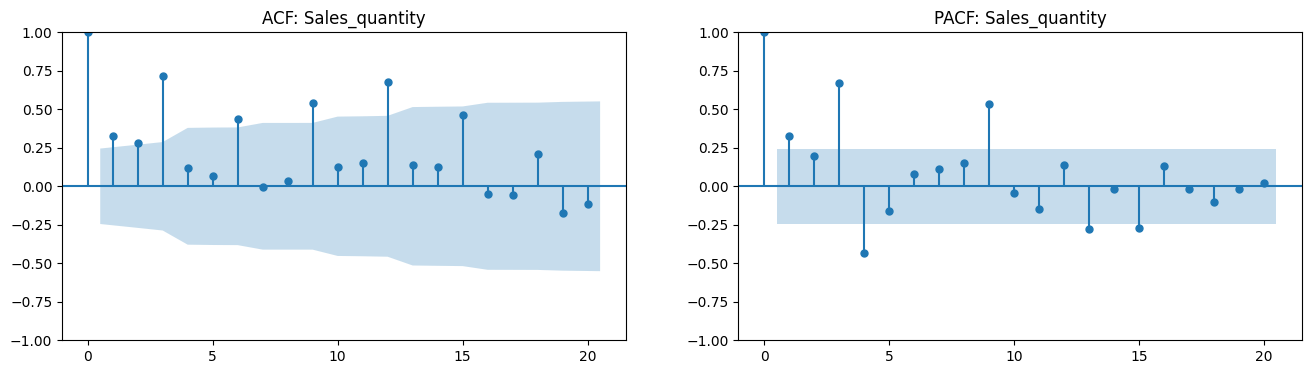

Autocorrelation and Partial Autocorrelation for Average_cost


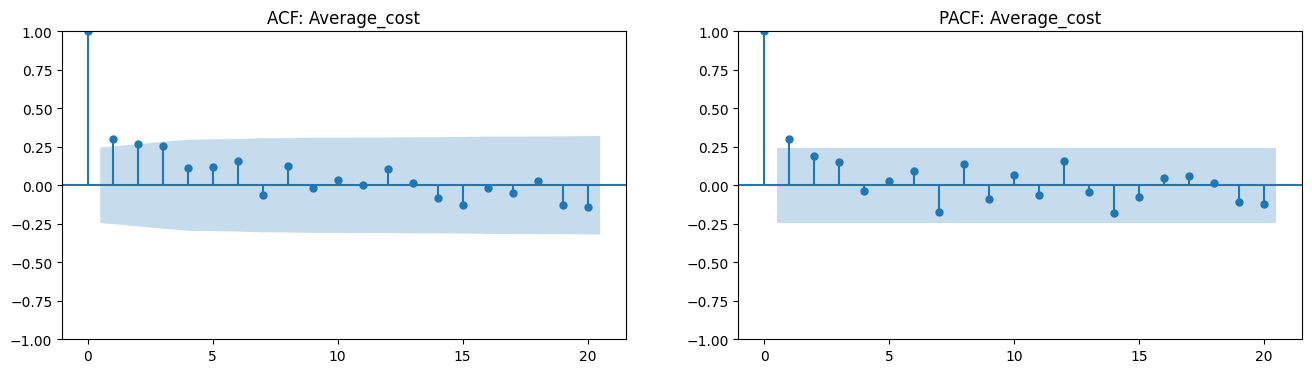

Autocorrelation and Partial Autocorrelation for The_average_annual_payroll_of_the_region


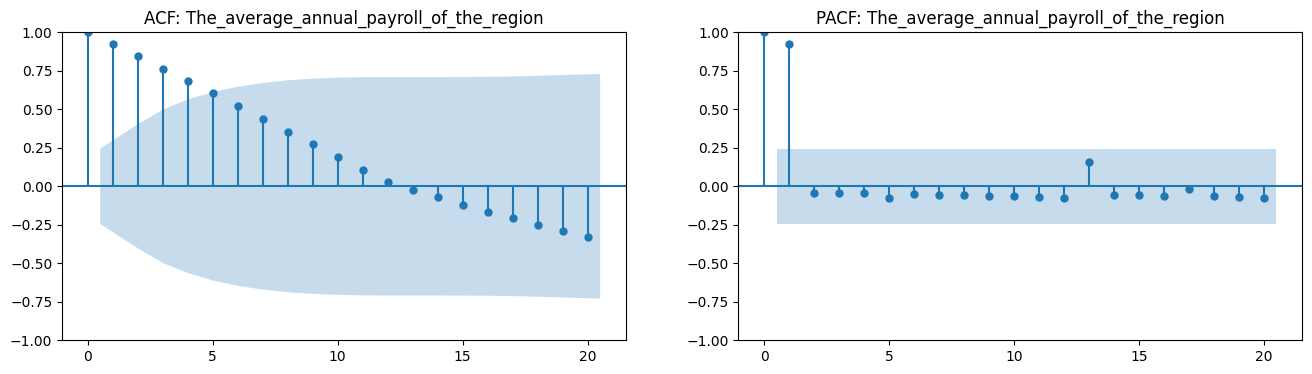

In [37]:
for column in df.columns:
    print(f"Autocorrelation and Partial Autocorrelation for {column}")
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(df[column], ax=axes[0], lags=20, title=f'ACF: {column}')
    plot_pacf(df[column], ax=axes[1], lags=20, title=f'PACF: {column}')
    plt.show()

In [38]:
# Create a new DataFrame with lagged versions of the original columns
lagged_df = pd.concat(
    [df.shift(i).add_suffix(f"_lag{i}") for i in range(1, 4)], axis=1  # Lag 1, 2, 3
)

# Concatenate the original DataFrame with the lagged features and remove any NaN values
lagged_df = pd.concat([df, lagged_df], axis=1).dropna()

# Display the first few rows of the new DataFrame with lagged values
print(lagged_df.head())


                 Revenue  Sales_quantity  Average_cost  \
Period                                                   
2015-01-04  1.881458e+07         15227.0   1235.606705   
2015-01-05  1.402148e+07          8620.0   1626.621765   
2015-01-06  1.678393e+07         13160.0   1275.374508   
2015-01-07  1.916189e+07         17254.0   1110.576805   
2015-01-08  1.520498e+07          8642.0   1759.428870   

            The_average_annual_payroll_of_the_region  Revenue_lag1  \
Period                                                               
2015-01-04                                30024676.0  2.204715e+07   
2015-01-05                                30024676.0  1.881458e+07   
2015-01-06                                30024676.0  1.402148e+07   
2015-01-07                                30024676.0  1.678393e+07   
2015-01-08                                30024676.0  1.916189e+07   

            Sales_quantity_lag1  Average_cost_lag1  \
Period                                          

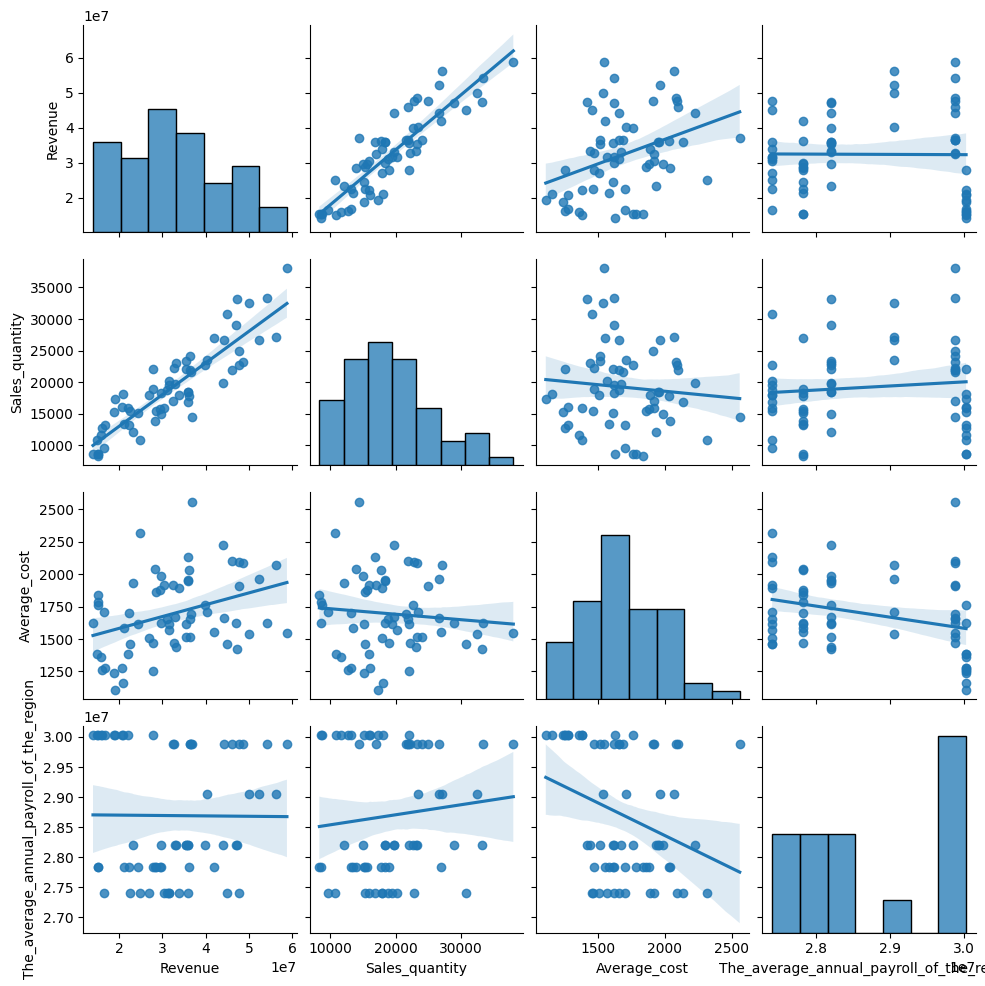

In [39]:
# Create pairwise scatter plots for all numerical columns in the DataFrame
sns.pairplot(df, kind="reg")

plt.show()